In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Read in Kilos dataset

In [2]:
os.chdir(r'C:\Users\hatzi\Documents\SUTD\Security Tools Projects\STL2 - Dark Web Scrape\datasets')
columns = ['site', 'vendor', 'timestamp', 'score', 'value_btc']
kilos_df = pd.read_csv('Darkweb data scrape.csv', usecols=columns)
kilos_df['timestamp'] = pd.to_numeric(kilos_df['timestamp'])
kilos_df['timestamp'] = pd.to_datetime(kilos_df['timestamp'],unit='s')
kilos_df.head()

,site,vendor,timestamp,score,value_btc
0,Samsara,Doubleup,1970-01-01,1.0,0.00022
1,Samsara,SocialPharma,1970-01-01,1.0,0.00492
2,Samsara,REAL-monoko,1970-01-01,1.0,0.00381
3,Samsara,druggiebearsofficial,1970-01-01,1.0,0.03159
4,Samsara,DrunkDragon,1970-01-01,1.0,0.00011


## Read in Agora dataset

In [3]:
agora_df = pd.read_csv('Agora/Agora.csv',  encoding="latin1")
agora_df.columns = [x.replace(" ", "") for x in agora_df.columns]

# Clean Price column
temp = agora_df["Price"].str.split(" ", n = 1, expand = True)
agora_df["Price"]= temp[0]
agora_df = agora_df.rename(columns={"Price": "Price_BTC"})
agora_df = agora_df[pd.to_numeric(agora_df['Price_BTC'], errors='coerce').notnull()]
agora_df['Price_BTC'] = pd.to_numeric(agora_df['Price_BTC'], errors='coerce')
print('Agora DF Length', len(agora_df))
agora_df.head()

Agora DF Length 109676


,Vendor,Category,Item,ItemDescription,Price_BTC,Origin,Destination,Rating,Remarks
0,CheapPayTV,Services/Hacking,12 Month HuluPlus gift Code,12-Month HuluPlus Codes for $25. They are wort...,0.050270,Torland,NaN,4.96/5,NaN
1,CheapPayTV,Services/Hacking,Pay TV Sky UK Sky Germany HD TV and much mor...,Hi we offer a World Wide CCcam Service for En...,0.152420,Torland,NaN,4.96/5,NaN
2,KryptykOG,Services/Hacking,OFFICIAL Account Creator Extreme 4.2,Tagged Submission Fix Bebo Submission Fix Adju...,0.007000,Torland,NaN,4.93/5,NaN
3,cyberzen,Services/Hacking,VPN > TOR > SOCK TUTORIAL,How to setup a VPN > TOR > SOCK super safe enc...,0.019017,NaN,NaN,4.89/5,NaN
4,businessdude,Services/Hacking,Facebook hacking guide,. This guide will teach you how to hack Faceb...,0.062018,Torland,NaN,4.88/5,NaN


## Augmenting Kilos dataset

### Join Kilos and Agora datasets based on vendor column

In [4]:
# Get unique vendor-category counts from agora df
# vendor_cat = agora_df.groupby(['Vendor','Category']).size().reset_index().rename(columns={0:'count'}).sort_values(["count"], ascending = False)
vendor_cat = agora_df.groupby(['Vendor','Category']).size().reset_index().rename(columns={0:'count'})
vendor_cat

,Vendor,Category,count
0,#NAME?,Drugs/Ecstasy/MDA,5
1,-BIGG-BALLs-,Counterfeits/Money,3
2,-BIGG-BALLs-,Drugs/Dissociatives/GHB,5
3,-BIGG-BALLs-,Drugs/Prescription,1
4,-Euphoria-,Drugs/Ecstasy/Pills,13
...,...,...,...
11608,~sweetpuff~,Drugs/Opioids/Other,2
11609,~sweetpuff~,Drugs/Prescription,2
11610,~sweetpuff~,Drugs/Psychedelics/Mescaline,3
11611,~sweetpuff~,Drugs/Psychedelics/Mushrooms,6


In [5]:
# Get unique vendor-category counts from agora df
vendor_cat = agora_df.groupby(['Vendor','Category']).size().reset_index().rename(columns={0:'count'})
vendor_cat = agora_df.groupby(['Vendor','Category']).size().reset_index().rename(columns={0:'count'}).sort_values(["count"], ascending = False)

# Filter for categories that are valid ie have a '/' inside
valid_vendor_cats = vendor_cat[vendor_cat['Category'].str.contains("/")].copy()

# Change vendors to lowercase
valid_vendor_cats['Vendor'] = valid_vendor_cats['Vendor'].str.lower()
kilos_df['vendor'] = kilos_df['vendor'].str.lower()

# Do a left join
joined_df = kilos_df.merge(valid_vendor_cats, left_on='vendor', right_on='Vendor', how='left', 
                          indicator = True)
joined_df = joined_df[joined_df['_merge'] == 'both']
joined_df = joined_df[['site', 'vendor', 'timestamp', 'score', 'value_btc', 'Category']].copy()

# Clean the category column
joined_df['category'], joined_df['sub_category_one'], joined_df['sub_category_two'] = '', '', ''
for index, row in joined_df.iterrows():
    string_cat = row['Category']
    
    # Clean category. Obtain primary category and sub category one
    category = string_cat
    subcategory_one = ''
    if '/' in string_cat:
        category = string_cat.split('/')[0]
        subcategory_one = string_cat.split('/')[1]
        
    # Check for sub category two
    subcategory_two = ''
    if string_cat.count('/') > 1: 
        subcategory_two = string_cat.split('/')[2]
    
    # Store the values
    joined_df.at[index, 'category'] = category
    joined_df.at[index, 'sub_category_one'] = subcategory_one
    joined_df.at[index, 'sub_category_two'] = subcategory_two

# Drop old Category column
joined_df = joined_df.drop(['Category'], axis=1)
    
joined_df.head()

,site,vendor,timestamp,score,value_btc,category,sub_category_one,sub_category_two
36,Samsara,instrument,1970-01-01,1.0,0.00623,Drugs,Psychedelics,LSD
37,Samsara,instrument,1970-01-01,1.0,0.00623,Drugs,Ecstasy,MDMA
38,Samsara,instrument,1970-01-01,1.0,0.00623,Drugs,Ecstasy,MDA
39,Samsara,instrument,1970-01-01,1.0,0.00623,Drugs,Stimulants,Meth
40,Samsara,instrument,1970-01-01,1.0,0.00623,Drugs,Ecstasy,Pills


In [54]:
joined_df.to_csv('category_sub_category.csv', index = False)

In [6]:
# Change dataframe name
kilos_category_df = joined_df.copy()

## Get popular categories

### Top Vendors for Drugs

In [7]:
# Combine Info, Data and Information columns
kilos_category_df.loc[kilos_category_df.category == "Info", "category"] = "Information"
kilos_category_df.loc[kilos_category_df.category == "Data", "category"] = "Information"

# Get percentages of each main category
kilos_category_df['category'].value_counts(normalize=True) * 100

Drugs                 87.663512
Services               3.897951
Information            3.894439
Tobacco                1.676821
Forgeries              0.986779
Counterfeits           0.953418
Drug paraphernalia     0.790125
Weapons                0.136955
Name: category, dtype: float64

In [8]:
# Get top vendors for drugs
drug_df = kilos_category_df[kilos_category_df['category'] == 'Drugs'].copy()
(drug_df['vendor'].value_counts(normalize=True) * 100).head(10)

quicklick           20.315661
uknextday           10.485309
dreamweaver          7.426843
angelina             6.749855
grandwizardslair     4.790995
boomers              4.374387
instrument           3.785527
nextgeneration       3.755483
calicannabisclub     3.074489
vitaminstore         2.571755
Name: vendor, dtype: float64

## Top Vendors across other Categories

In [9]:
# Get top 10 vendors for each category 
top_vendors_overall = {}
for category in kilos_category_df.category.unique(): 
    sub_df = kilos_category_df[kilos_category_df['category'] == category]
    top_ten_vendors = sub_df['vendor'].value_counts(normalize = True).head(10)
    top_ten_vendors = top_ten_vendors.index.values
    top_vendors_overall[category] = top_ten_vendors
pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in top_vendors_overall.items() ]))

,Drugs,Drug paraphernalia,Services,Forgeries,Information,Tobacco,Counterfeits,Weapons
0,quicklick,joeybagadonuts,sexyhomer,namedeclined,dionysos,maling47,sexyhomer,dionysos
1,uknextday,namedeclined,joeybagadonuts,lindalovelace,namedeclined,NaN,dionysos,NaN
2,dreamweaver,dionysos,namedeclined,arctic,sexyhomer,NaN,hackyboy,NaN
3,angelina,NaN,hackyboy,medsguru,ukpharma,NaN,moggymoo,NaN
4,grandwizardslair,NaN,biocanna,kingscan,hackyboy,NaN,NaN,NaN
5,boomers,NaN,weednation,threekings,colombiaconnection,NaN,NaN,NaN
6,instrument,NaN,shponglestarship,NaN,etimbuk,NaN,NaN,NaN
7,nextgeneration,NaN,etimbuk,NaN,goingpostal,NaN,NaN,NaN
8,calicannabisclub,NaN,medsguru,NaN,medsguru,NaN,NaN,NaN
9,vitaminstore,NaN,dutchmagic,NaN,NaN,NaN,NaN,NaN


## Sales over Time (Overall)

In [10]:
# Extract rows which have a valid time
time_df = kilos_category_df[kilos_category_df['timestamp'] > '1970-01-01'].copy()
print('Length before time filtering:', len(kilos_category_df))
print('Length after time filtering', len(time_df))

Length before time filtering: 56953
Length after time filtering 54604


<AxesSubplot:xlabel='timestamp,timestamp'>

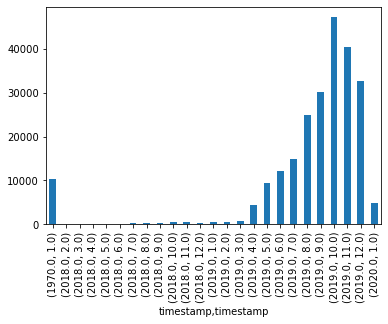

In [11]:
time_df = kilos_df[['timestamp', 'site']]
time_df = time_df.rename(columns={"site": "counts"})
time_df['counts'].groupby([time_df["timestamp"].dt.year, time_df["timestamp"].dt.month]).count().plot(kind="bar")

## Sales over Time (for each category)

In [12]:
def print_category(category):
    # Extract data relating to category
    time_df = kilos_category_df[kilos_category_df['timestamp'] > '1970-01-01'].copy()
    time_df = time_df[['timestamp', 'site', 'category']]
    time_df = time_df.rename(columns={"site": "counts"})
    category_df = time_df[time_df['category'] == category].copy()
    category_df = category_df.drop(['category'], axis=1)
    
    # Print graph of counts vs time
    fig = plt.figure()
    ax1 = category_df['counts'].groupby([time_df["timestamp"].dt.year, time_df["timestamp"].dt.month]).count().plot(kind="bar")
    ax1.title.set_text('Plot of {} vs time'.format(category))

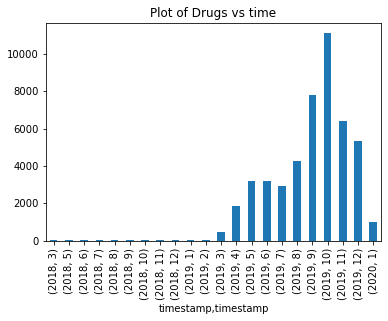

In [13]:
print_category('Drugs')

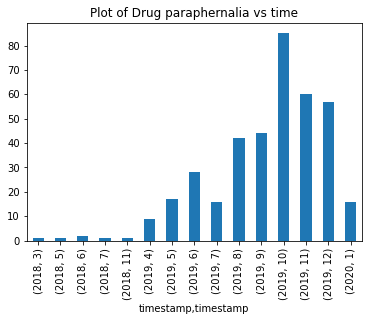

In [14]:
print_category('Drug paraphernalia')

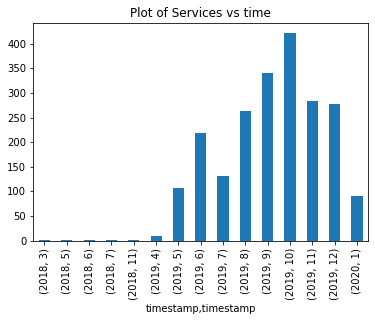

In [15]:
print_category('Services')

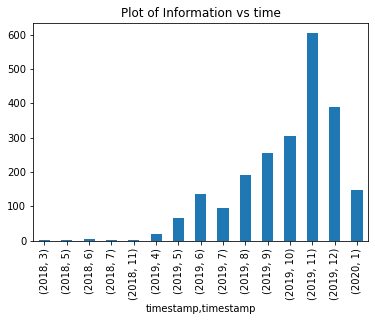

In [16]:
print_category('Information')

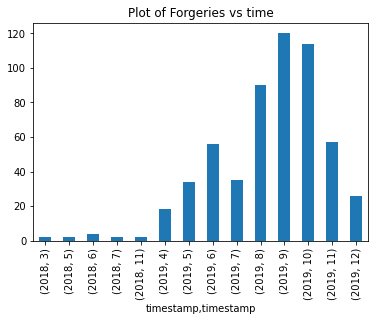

In [17]:
print_category('Forgeries')

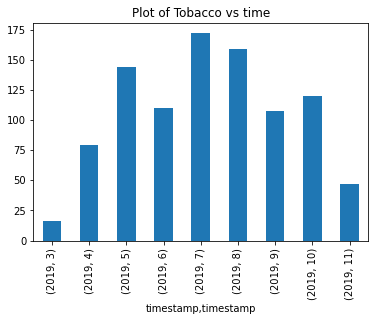

In [18]:
print_category('Tobacco')

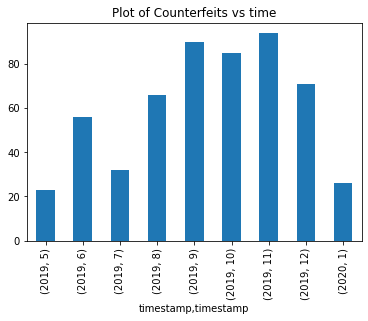

In [19]:
print_category('Counterfeits')

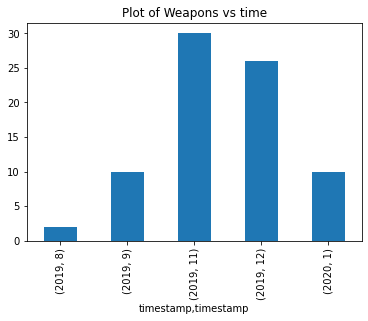

In [20]:
print_category('Weapons')

## Sales over Time (for each Site)

In [21]:
# Read in original dataset
columns = ['site', 'vendor', 'timestamp', 'score', 'value_btc']
original_df = pd.read_csv('Darkweb data scrape.csv', usecols=columns)
original_df['timestamp'] = pd.to_numeric(original_df['timestamp'])
original_df['timestamp'] = pd.to_datetime(original_df['timestamp'],unit='s')

In [22]:
def print_time_site(site):
    site_df = original_df[original_df['site'] == site].copy()
    time_df = site_df.copy()
    time_df = time_df[['timestamp', 'site']]
    time_df = time_df.rename(columns={"site": "counts"})
    plotting_df = time_df.copy()
    
    fig = plt.figure()
    ax1 = plotting_df['counts'].groupby([plotting_df["timestamp"].dt.year, plotting_df["timestamp"].dt.month]).count().plot(kind="bar")
    ax1.title.set_text('Timeplot of {}'.format(site))

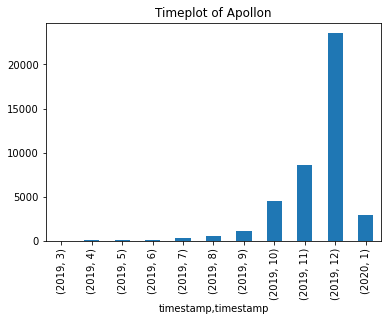

In [23]:
print_time_site('Apollon')

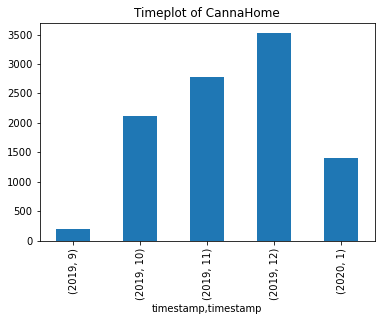

In [24]:
print_time_site('CannaHome')

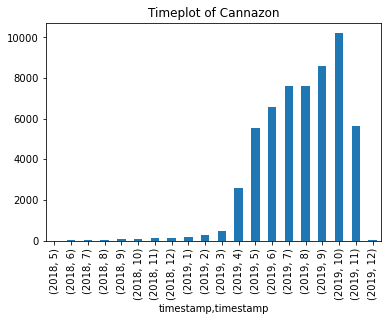

In [25]:
print_time_site('Cannazon')

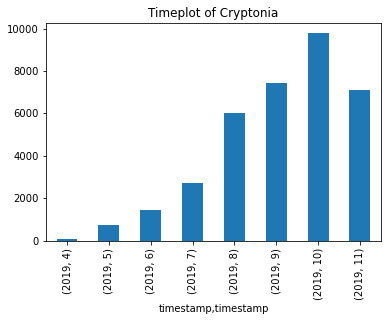

In [26]:
print_time_site('Cryptonia')

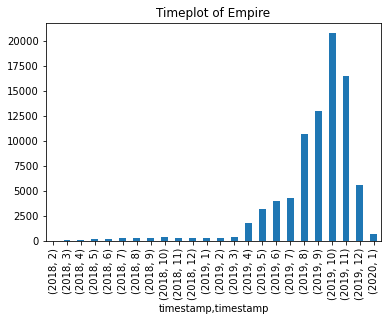

In [27]:
print_time_site('Empire')

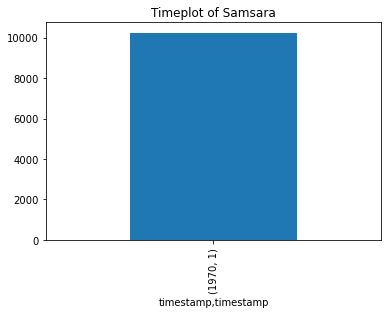

In [28]:
print_time_site('Samsara')

## Popular markets (by Category)

In [29]:
def get_market_popularity_for_category(category): 
    
    # Print percentage counts
    category_df = kilos_category_df.copy()
    category_df = category_df[category_df['category'] == category]
    value_counts = category_df['site'].value_counts(normalize=True) * 100
    print('% counts for {}'.format(category))
    print(value_counts, '\n')
    
    # Print pie chart
    fig = plt.figure()
    ax1 = category_df.groupby('site').size().plot(kind='pie', autopct ='%.1f')
    ax1.title.set_text('Popularity of sites for {}'.format(category))

% counts for Drugs
Cannazon     34.640575
Empire       27.628337
Cryptonia    16.886655
Apollon      10.659563
CannaHome     5.760410
Samsara       4.424460
Name: site, dtype: float64 



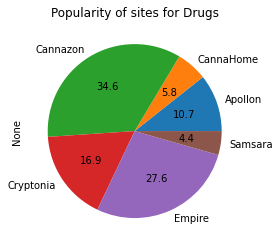

In [30]:
get_market_popularity_for_category('Drugs')

% counts for Drug paraphernalia
Empire       44.888889
CannaHome    26.666667
Samsara      15.555556
Apollon      11.111111
Cryptonia     1.777778
Name: site, dtype: float64 



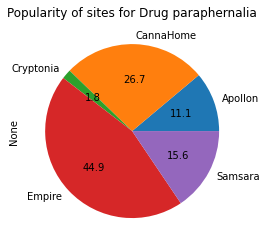

In [31]:
get_market_popularity_for_category('Drug paraphernalia')

% counts for Services
Empire       72.432432
Apollon      10.810811
CannaHome    10.135135
Cryptonia     3.288288
Samsara       3.153153
Cannazon      0.180180
Name: site, dtype: float64 



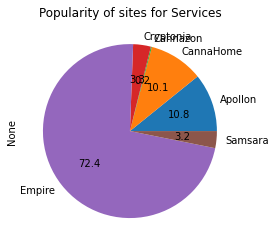

In [32]:
get_market_popularity_for_category('Services')

% counts for Information
Empire       54.508566
Apollon      37.060415
Cryptonia     8.431019
Name: site, dtype: float64 



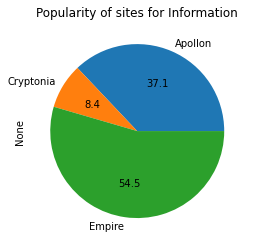

In [33]:
get_market_popularity_for_category('Information')

% counts for Forgeries
Empire       71.886121
Cryptonia    20.284698
Apollon       7.829181
Name: site, dtype: float64 



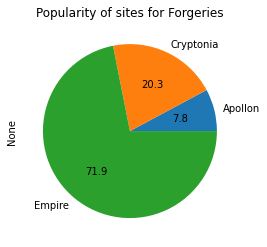

In [34]:
get_market_popularity_for_category('Forgeries')

% counts for Tobacco
Cannazon    100.0
Name: site, dtype: float64 



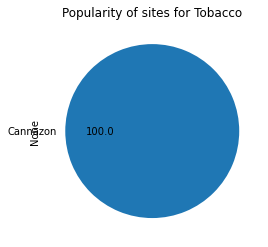

In [35]:
get_market_popularity_for_category('Tobacco')

% counts for Weapons
Apollon      79.487179
Cryptonia    20.512821
Name: site, dtype: float64 



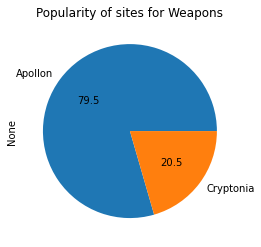

In [36]:
get_market_popularity_for_category('Weapons')

% counts for Counterfeits
Empire       74.401473
Apollon      22.283610
Cryptonia     2.946593
Cannazon      0.368324
Name: site, dtype: float64 



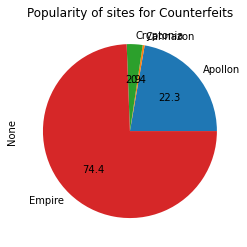

In [37]:
get_market_popularity_for_category('Counterfeits')

## Vendor Lifetimes

In [38]:
# Read in original dataset
columns = ['site', 'vendor', 'timestamp', 'score', 'value_btc']
original_df = pd.read_csv('Darkweb data scrape.csv', usecols=columns)
original_df['timestamp'] = pd.to_numeric(original_df['timestamp'])
original_df['timestamp'] = pd.to_datetime(original_df['timestamp'],unit='s')

# Exclude rows that have incorrect timestamps
original_df = original_df[original_df['timestamp'] > '1970-01-01'].copy()
len(original_df)

225414

In [39]:
# Get list of vendors
vendor_list = original_df['vendor'].unique()
vendor_timespans = []

for vendor in vendor_list:
    vendor_df = original_df[original_df['vendor'] == vendor]
    vendor_start = vendor_df['timestamp'].min()
    vendor_latest = vendor_df['timestamp'].max()
    timespan = vendor_latest - vendor_start
    vendor_timespans.append(timespan)
    
timespan_df = pd.DataFrame({
    'vendor': vendor_list, 
    'timespan': vendor_timespans
})

timespan_df = timespan_df.sort_values(by=['timespan'], ascending = False)
timespan_df.head(10)

,vendor,timespan
1,DrunkDragon,675 days 09:18:00
0,ofgrey,670 days 00:20:00
3,Goldoratt,649 days 06:13:00
5,MoneyMule,637 days 13:06:00
4,rvaska,623 days 12:06:00
6,HeinekenExpress,616 days 13:32:00
9,tvman,605 days 04:26:00
2,namedeclined,603 days 07:43:00
10,sixandeight,600 days 09:00:00
11,jimmy2018,597 days 00:15:00


In [40]:
## Get ratings for the top 10 vendors that last long
vendors = timespan_df.head(10).vendor

average_ratings, median_ratings = [],[]
for vendor in vendors: 
    vendor_df = original_df[original_df['vendor'] == vendor]
    average_rating = vendor_df['score'].mean()
    median_rating = vendor_df['score'].median()
    var_rating = vendor_df['score'].var()
    
    average_ratings.append(average_rating)
    median_ratings.append(median_rating)
   
    
vendor_rating_df = pd.DataFrame({
    'vendor': vendors, 
    'average_rating': average_ratings, 
    'median_rating': median_ratings 
})
vendor_rating_df.head(10)

,vendor,average_rating,median_rating
1,DrunkDragon,0.520179,1.0
0,ofgrey,0.875000,1.0
3,Goldoratt,0.537755,1.0
5,MoneyMule,0.811554,1.0
4,rvaska,0.597345,1.0
6,HeinekenExpress,0.337818,1.0
9,tvman,0.758818,1.0
2,namedeclined,0.925743,1.0
10,sixandeight,0.829046,1.0
11,jimmy2018,0.923913,1.0


In [41]:
# See if there is a correlation between vendor timespan and ratings
timespan_df['average_rating'], timespan_df['median_rating'] = '', ''

for index, row in timespan_df.iterrows(): 
    current_vendor = row['vendor']
    
    # Extract average and median ratings
    vendor_df = original_df[original_df['vendor'] == current_vendor]
    average_rating = vendor_df['score'].mean()
    median_rating = vendor_df['score'].median()
    
    # Store values
    timespan_df.loc[index, 'average_rating'] = average_rating
    timespan_df.loc[index, 'median_rating'] = median_rating
    
timespan_df = timespan_df.astype({'average_rating': 'int32', 
                                  'median_rating': 'int32'})

# Convert time delta to seconds
timespan_df['timespan'] = timespan_df['timespan'] / np.timedelta64(1, 's')

timespan_df.corr()

,timespan,average_rating,median_rating
timespan,1.000000,-0.493012,0.034303
average_rating,-0.493012,1.000000,0.166549
median_rating,0.034303,0.166549,1.000000


## Vendor that earns most money

In [42]:
# Read in original dataset
columns = ['site', 'vendor', 'timestamp', 'score', 'value_btc']
original_df = pd.read_csv('Darkweb data scrape.csv', usecols=columns)
original_df['timestamp'] = pd.to_numeric(original_df['timestamp'])
original_df['timestamp'] = pd.to_datetime(original_df['timestamp'],unit='s')

vendors = original_df['vendor'].unique()
vendor_earnings = []

for vendor in vendors:
    vendor_df = original_df[original_df['vendor'] == vendor]
    vendor_earning = vendor_df['value_btc'].sum()
    vendor_earnings.append(vendor_earning)
    
earnings_df = pd.DataFrame({
    'vendor': vendors, 
    'total_btc_earnings': vendor_earnings
})
earnings_df = earnings_df.sort_values(by=['total_btc_earnings'], ascending = False)
earnings_df.head(10)

,vendor,total_btc_earnings
436,CaliTerps,2088.068601
365,Insta,384.991341
190,GreenSupreme,325.015451
434,MexicanConnection,303.519171
423,cabackdoormedical,172.616300
880,NancyBotwin2019,156.940364
652,iROCKice,149.513500
331,VanillaSurf,131.068990
274,tonystarkweed,129.423152
605,CTB,123.932000


In [43]:
# See what categories are these vendors in 
top_vendors = earnings_df.head(10)['vendor']

# Read in dataset with categories
augmented_kilo = pd.read_csv('web_scrape_category.csv')
augmented_kilo['timestamp'] = pd.to_datetime(augmented_kilo['timestamp'])

# See if any of the top vendors are in the augmented kilo dataset
for vendor in top_vendors:
    if vendor in augmented_kilo['vendor'].unique():
        print(vendor)

In [44]:
# Analyze relationship between earnings and ratings
earnings_df['average_rating'], earnings_df['median_rating'] = -1, -1
for index, row in earnings_df.iterrows():
    vendor = row['vendor']
    
    # Get ratings corresponding to vendor
    vendor_ratings = original_df[original_df['vendor'] == vendor]
    
    # Store average rating
    earnings_df.loc[index, 'average_rating'] = vendor_ratings['score'].mean()
    earnings_df.loc[index, 'median_rating'] = vendor_ratings['score'].median()
    
earnings_df.corr()

,total_btc_earnings,average_rating,median_rating
total_btc_earnings,1.000000,0.024957,0.007493
average_rating,0.024957,1.000000,0.738488
median_rating,0.007493,0.738488,1.000000


In [45]:
# Top 13 in terms of earnings
top_earnings = earnings_df.head(13)
top_earnings.corr()

,total_btc_earnings,average_rating,median_rating
total_btc_earnings,1.000000,-0.526313,NaN
average_rating,-0.526313,1.000000,NaN
median_rating,NaN,NaN,NaN


## Combine with Darknet market cocaine listings

In [46]:
darknet_df = pd.read_csv('Darknet Market Cocaine Listings/dream_market_cocaine_listings.csv', thousands=",")

In [47]:
coccaine_vendors = []
for kilos_vendor in kilos_df['vendor'].unique(): 
    if kilos_vendor in darknet_df['vendor_name'].unique():
        coccaine_vendors.append(kilos_vendor)
print('Number of common vendors:', len(coccaine_vendors))
print(coccaine_vendors)

Number of common vendors: 6
['onenation', 'homegrow1919', 'dutchcandyshop', 'ukwhite', 'superdrugz', 'drugkingz']


In [48]:
# Get ratings for kilos dataset
sub_ratings = kilos_df[kilos_df['vendor'].isin(coccaine_vendors)]
sub_ratings = sub_ratings[['vendor', 'score']]
print('Data from Kilos dataset:')
sub_ratings.groupby('vendor')['score'].mean()

Data from Kilos dataset:


vendor
drugkingz         1.000000
dutchcandyshop    0.886957
homegrow1919      1.000000
onenation         0.972093
superdrugz        1.000000
ukwhite           1.000000
Name: score, dtype: float64

In [49]:
# Get ratings from Cocaine dataset
sub_ratings = darknet_df[darknet_df['vendor_name'].isin(coccaine_vendors)]
sub_ratings = sub_ratings[['vendor_name', 'rating']]
print('Data from Cocaine dataset:')
sub_ratings.groupby('vendor_name')['rating'].mean()

Data from Cocaine dataset:


vendor_name
drugkingz         4.89
dutchcandyshop    4.66
homegrow1919      4.96
onenation         4.84
superdrugz        4.94
ukwhite           4.88
Name: rating, dtype: float64

## Combine with Silk Road 2 Dataset

In [50]:
silk_road_df = pd.read_excel('Silk Road 2 Listings/mastersr2.xlsx')

In [51]:
silk_road_vendors = []
for kilos_vendor in kilos_df['vendor'].unique(): 
    if kilos_vendor in silk_road_df['Sellerid'].unique():
        silk_road_vendors.append(kilos_vendor)
print('Number of common vendors:', len(silk_road_vendors))
print(silk_road_vendors)

Number of common vendors: 11
['instrument', 'namedeclined', 'theanchor', 'revenantchild', 'arctic', 'nzt48givesyouwings', 'puffinbilly', 'weednation', 'shroomdude', 'meerkovo', 'calitreez']


In [52]:
# Get ratings for kilos dataset
sub_ratings = kilos_df[kilos_df['vendor'].isin(silk_road_vendors)]
sub_ratings = sub_ratings[['vendor', 'score']]
print('Data from Kilos dataset:')
sub_ratings.groupby('vendor')['score'].mean()

Data from Kilos dataset:


vendor
arctic                0.888889
calitreez             1.000000
instrument            0.994709
meerkovo              0.857143
namedeclined          0.925743
nzt48givesyouwings    1.000000
puffinbilly           1.000000
revenantchild         1.000000
shroomdude            1.000000
theanchor             0.800000
weednation            0.984615
Name: score, dtype: float64

In [53]:
# Get ratings for Silk Road dataset
sub_ratings = silk_road_df[silk_road_df['Sellerid'].isin(silk_road_vendors)]
sub_ratings = sub_ratings[['Sellerid', 'Rating']]
print('Data from Silk Road dataset:')
sub_ratings.groupby('Sellerid')['Rating'].mean()

Data from Silk Road dataset:


Sellerid
arctic                4.750000
calitreez                  NaN
instrument            4.800581
meerkovo              4.752597
namedeclined               NaN
nzt48givesyouwings    4.786532
puffinbilly           4.855844
revenantchild         4.738312
shroomdude            4.650000
theanchor             3.700000
weednation                 NaN
Name: Rating, dtype: float64